# Classical Uniform Electron Beam Simulation

This notebook simulates the trajectory of electrons in a time-varying magnetic field and visualizes the pattern formed on a screen. It is based on the `classical-uniform.py` script.

## 1. Imports

Import necessary libraries: `numpy` for numerical operations, `scipy` for solving ordinary differential equations, and `matplotlib` for plotting.

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import imageio
import os

## 2. Physical Constants and Simulation Parameters

Define the physical constants (in Gaussian units) and the parameters for the simulation.

In [2]:
# Physical constants (Gaussian units)
m_e = 9.10938356e-28  # Mass of electron (g)
e_charge = 4.80320425e-10 # Charge of electron (statcoulomb or esu)
c_light = 2.99792458e10   # Speed of light (cm/s)

# Simulation parameters
# CRITICAL FIX: Reduced B-field strength to prevent non-physical velocities.
# The original value of 10.0 G caused numerical instability.
B_02_sim = 0.1   # Gauss
B_03_sim = 0.1   # Gauss
w_2_sim = 1.0e7    # rad/s
w_3_sim = 1.5e7    # rad/s
L_sim = 100.0      # cm (length of the beam path to the screen)
v_initial_sim = c_light / 10.0 # Initial velocity in x1 direction

num_electrons_sim = 200 # Number of electrons to simulate

## 3. B-Field Definitions

Functions to define the time-varying magnetic fields $B_2(t)$ and $B_3(t)$ and their time derivatives.

In [3]:
def B2_field(t, B_02_param, w_2_param):
    return B_02_param * np.sin(w_2_param * t)

def dB2_dt_field(t, B_02_param, w_2_param):
    return B_02_param * w_2_param * np.cos(w_2_param * t)

def B3_field(t, B_03_param, w_3_param):
    return B_03_param * np.sin(w_3_param * t)

def dB3_dt_field(t, B_03_param, w_3_param):
    return B_03_param * w_3_param * np.cos(w_3_param * t)

## 4. Equations of Motion

Defines the system of ordinary differential equations (ODEs) that describe the motion of an electron in the magnetic fields. 

The ODE function takes `t_offset` as an argument. This offset represents the launch time of a specific electron on a global clock, allowing us to simulate electrons launched at different phases of the oscillating B-fields.

In [4]:
# REFACTORED: The ODE function is now defined once and takes t_offset as an argument.
# This is a cleaner and more robust approach than redefining a function in each loop iteration.
def equations_of_motion(t_particle, y, m, e, c, B_02_param, w_2_param, B_03_param, w_3_param, t_offset):
    # The B-field evolves on a global clock. Its phase depends on when the electron was launched (t_offset).
    # The solver's time, t_particle, is the time since that specific electron's launch.
    global_t = t_particle + t_offset
    
    x1, x2, x3, v1, v2, v3 = y
    
    B2_t = B2_field(global_t, B_02_param, w_2_param)
    dB2_dt_t = dB2_dt_field(global_t, B_02_param, w_2_param)
    B3_t = B3_field(global_t, B_03_param, w_3_param)
    dB3_dt_t = dB3_dt_field(global_t, B_03_param, w_3_param)
    
    # The equations of motion as provided in the notebook
    a1 = (e / (2 * m * c)) * (x3 * dB2_dt_t - x2 * dB3_dt_t)
    a2 = (e / (m * c)) * (0.5 * x1 * dB3_dt_t - v1 * B3_t)
    a3 = (e / (m * c)) * (-0.5 * x1 * dB2_dt_t + v1 * B2_t)
    
    return [v1, v2, v3, a1, a2, a3]

## 5. Simulate Electron Trajectories

This section simulates the trajectories of multiple electrons. Each electron is launched at a slightly different time (`t_offset`) to capture the effect of the oscillating fields. The final positions of the electrons on a screen located at $x_1 = L$ are recorded.

In [5]:
screen_positions_x2 = []
screen_positions_x3 = []

# Approximate time of flight for one electron. Used to set the integration interval.
t_flight_approx = L_sim / v_initial_sim
t_span = (0, t_flight_approx) 

# REVISED LOGIC/COMMENT: The following clarifies how electrons are launched.
# To generate a pattern, we simulate electrons launched at different times into the
# oscillating magnetic fields. This is modeled with a 't_offset' for each electron,
# representing its launch time on a global clock. This is equivalent to applying
# a different initial phase of the B-fields for each electron.
characteristic_period = 2 * np.pi / max(w_2_sim, w_3_sim)
total_launch_time = characteristic_period * 5 # Launch electrons over 5 cycles of the faster B-field

print(f"Approximate time of flight: {t_flight_approx:.2e} s")
print(f"Simulating {num_electrons_sim} electrons...")

for i in range(num_electrons_sim):
    # This offset simulates launching electrons sequentially into the evolving B-fields.
    t_offset = (i / num_electrons_sim) * total_launch_time

    # Initial conditions: [x1, x2, x3, v1, v2, v3]
    y0 = [0, 0, 0, v_initial_sim, 0, 0]
    
    # Set evaluation times for dense output. Ensures smooth trajectory data.
    num_time_points = int(max(w_2_sim, w_3_sim) * t_flight_approx / (2*np.pi) * 30)
    num_time_points = max(num_time_points, 200) 
    t_eval = np.linspace(t_span[0], t_span[1], num_time_points)

    # REFACTORED: Use the 'args' parameter to pass arguments to the ODE function.
    # This is the standard, efficient, and correct way to handle changing parameters in a loop.
    sol = solve_ivp(
        fun=equations_of_motion, 
        t_span=t_span, 
        y0=y0, 
        method='RK45',
        dense_output=True, # Recommended for accurate final point interpolation
        t_eval=t_eval,
        args=(m_e, e_charge, c_light, B_02_sim, w_2_sim, B_03_sim, w_3_sim, t_offset)
    )
    
    # Extract the final position on the screen
    final_state = sol.y[:, -1]
    screen_positions_x2.append(final_state[1])
    screen_positions_x3.append(final_state[2])
    
    if (i+1) % (num_electrons_sim // 10) == 0:
        print(f"  Simulated {i+1}/{num_electrons_sim} electrons...")

print("Simulation complete.")

Approximate time of flight: 3.34e-08 s
Simulating 200 electrons...
  Simulated 20/200 electrons...
  Simulated 40/200 electrons...
  Simulated 60/200 electrons...


  Simulated 80/200 electrons...
  Simulated 100/200 electrons...
  Simulated 120/200 electrons...
  Simulated 140/200 electrons...


  Simulated 160/200 electrons...
  Simulated 180/200 electrons...
  Simulated 200/200 electrons...
Simulation complete.


## 6. Plot the Screen Pattern

Visualize the positions of the electrons on the screen. This creates a scatter plot of $(x_2, x_3)$ coordinates.


Generating GIF frames for electron_beam_pattern.gif...


  Generated frame 20/200...


  Generated frame 40/200...


  Generated frame 60/200...


  Generated frame 80/200...


  Generated frame 100/200...


  Generated frame 120/200...


  Generated frame 140/200...


  Generated frame 160/200...


  Generated frame 180/200...


  Generated frame 200/200...


GIF saved to /app/Electron-Experiment/Sim/electron_beam_pattern.gif


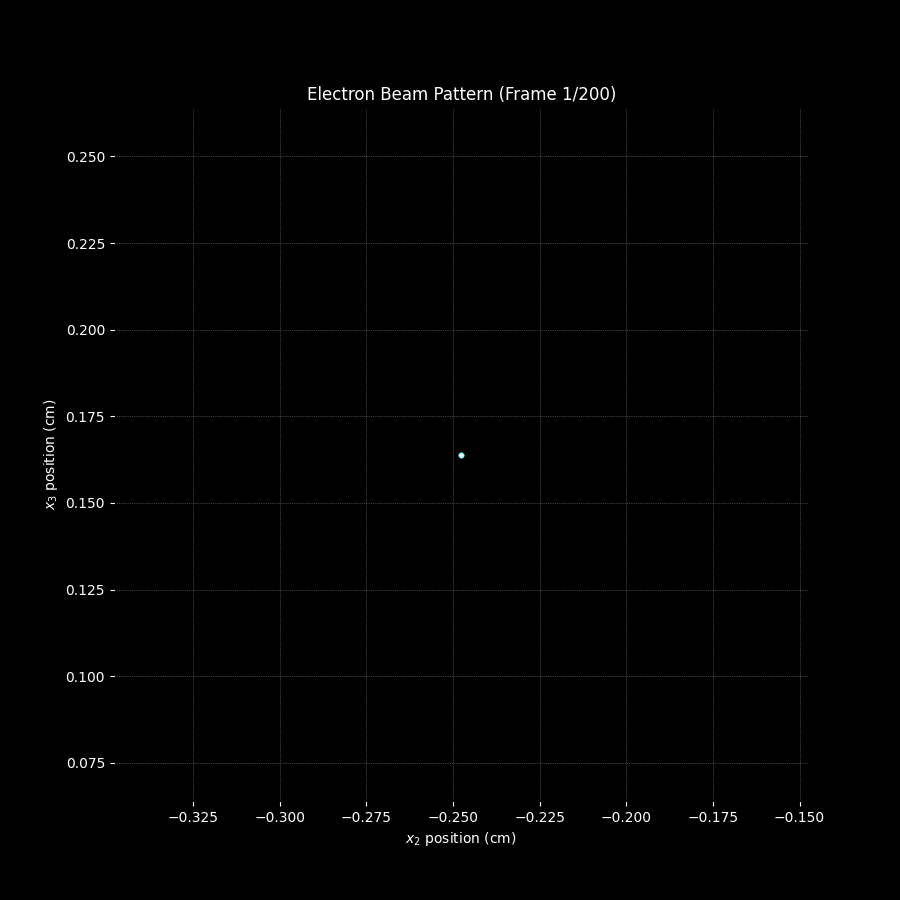

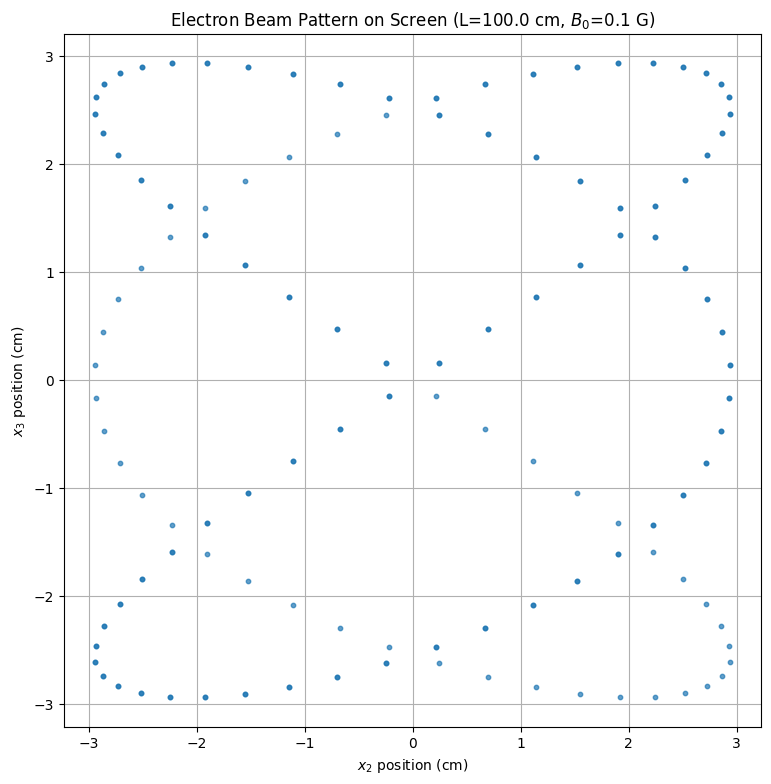

In [6]:
plt.figure(figsize=(9, 9))
plt.scatter(screen_positions_x2, screen_positions_x3, s=10, alpha=0.7)
plt.title(f'Electron Beam Pattern on Screen (L={L_sim} cm, $B_0$={B_02_sim} G)')
plt.xlabel('$x_2$ position (cm)')
plt.ylabel('$x_3$ position (cm)')
plt.grid(True)
plt.axis('equal')
# plt.show() # Replaced by GIF generation

# --- GIF Generation Parameters ---
gif_filename = 'electron_beam_pattern.gif'
gif_path = os.path.join(os.getcwd(), gif_filename) # Save in the current notebook directory
num_frames = num_electrons_sim # One frame per electron for simplicity, can be adjusted
decay_factor = 0.8 # How much the alpha of a point decreases each frame it persists
min_alpha = 0.1 # Minimum alpha before a point is removed
fps = 10 # Frames per second for the GIF

# --- Generate Frames for GIF ---
writer = imageio.get_writer(gif_path, fps=fps)
history_points = [] # Stores (x2, x3, initial_alpha, current_alpha, age)

print(f"\nGenerating GIF frames for {gif_filename}...")

fig_gif, ax_gif = plt.subplots(figsize=(9, 9))

for i in range(num_electrons_sim):
    # Add the new point from this electron
    new_x2 = screen_positions_x2[i]
    new_x3 = screen_positions_x3[i]
    history_points.append([new_x2, new_x3, 1.0, 1.0, 0]) # x2, x3, initial_alpha, current_alpha, age
    
    ax_gif.clear()
    ax_gif.set_facecolor('black') # Set background to black for better visibility of points
    fig_gif.patch.set_facecolor('black')

    # Update and draw points
    current_frame_points_x2 = []
    current_frame_points_x3 = []
    current_frame_alphas = []
    
    next_history_points = []
    for point_data in history_points:
        px, py, initial_a, current_a, age = point_data
        current_frame_points_x2.append(px)
        current_frame_points_x3.append(py)
        current_frame_alphas.append(current_a)
        
        # Decay alpha for next frame
        next_alpha = current_a * decay_factor
        if next_alpha >= min_alpha:
            next_history_points.append([px, py, initial_a, next_alpha, age + 1])
            
    history_points = next_history_points

    if current_frame_points_x2: # Check if there are any points to plot
        ax_gif.scatter(current_frame_points_x2, current_frame_points_x3, s=15, 
                       c=current_frame_alphas, cmap='Blues_r', vmin=0, vmax=1.0, 
                       edgecolors='cyan', linewidths=0.5) # Brighter points with cyan edges

    ax_gif.set_title(f'Electron Beam Pattern (Frame {i+1}/{num_electrons_sim})', color='white')
    ax_gif.set_xlabel('$x_2$ position (cm)', color='white')
    ax_gif.set_ylabel('$x_3$ position (cm)', color='white')
    ax_gif.grid(True, color='gray', linestyle=':', linewidth=0.5)
    ax_gif.tick_params(axis='x', colors='white')
    ax_gif.tick_params(axis='y', colors='white')
    
    # Determine plot limits dynamically based on all points simulated so far
    if screen_positions_x2 and screen_positions_x3: # Ensure lists are not empty
        all_x2 = np.array(screen_positions_x2[:i+1])
        all_x3 = np.array(screen_positions_x3[:i+1])
        margin = 0.1 * max( (all_x2.max()-all_x2.min() if all_x2.size >1 else 1),
                             (all_x3.max()-all_x3.min() if all_x3.size >1 else 1) )
        margin = max(margin, 0.1) # Ensure a minimum margin
        
        ax_gif.set_xlim(all_x2.min() - margin, all_x2.max() + margin)
        ax_gif.set_ylim(all_x3.min() - margin, all_x3.max() + margin)
    else: # Default limits if no points yet (should not happen if simulation runs correctly)
        ax_gif.set_xlim(-L_sim*0.1, L_sim*0.1)
        ax_gif.set_ylim(-L_sim*0.1, L_sim*0.1)
        
    ax_gif.set_aspect('equal', adjustable='box')
    
    fig_gif.canvas.draw()
    # Convert the canvas to an RGB numpy array
    image_rgba = np.asarray(fig_gif.canvas.buffer_rgba())
    image_rgb = image_rgba[:, :, :3] # Drop the alpha channel
    writer.append_data(image_rgb)
    
    if (i+1) % (num_electrons_sim // 10) == 0:
        print(f"  Generated frame {i+1}/{num_electrons_sim}...")

writer.close()
plt.close(fig_gif) # Close the figure used for GIF generation
print(f"GIF saved to {gif_path}")

# Display the GIF in the notebook (optional, may not work in all environments)
from IPython.display import Image as IPImage
if os.path.exists(gif_path):
    display(IPImage(filename=gif_path))
else:
    print(f"Could not find GIF at {gif_path} to display.")